In [1]:
import lbforaging
import numpy as np
import time
import matplotlib.pyplot as plt

from games.foraging import Foraging
from agents.iql_agent import IQLAgent, IQLAgentConfig

In [2]:
game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-8x8-2p-1f-v3",
        "Foraging-8x8-3p-1f-v3",
        "Foraging-8x8-3p-1f-coop-v3",
    ]

In [3]:
configurations = {
    '0' : {
        'game': game_config[0],
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=1000, seed=1),
        'train_config': {
            'episodes': 100,
            'iterations': 10,
        }
    },
    '1' : {
        'game': game_config[1],
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=10000, seed=1),
        'train_config': {
            'episodes': 100,
            'iterations': 50,
        }
    },
    '2' : {
        'game': game_config[2],
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=20000, seed=1),
        'train_config': {
            'episodes': 100,
            'iterations': 100,
        }
    },
    '3' : {
        'game': game_config[3],
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=60000, seed=1),
        'train_config': {
            'episodes': 1000,
            'iterations': 100,
        }
    }
}

In [4]:
config = configurations['0']
game = Foraging(config=config['game'], seed=1)
agents = dict(map(lambda agent: (agent, IQLAgent(game=game, agent=agent, config=config['iql'])), game.agents))

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
game.reset()
for agent in game.agents:
    print(f"Agent: {agent}")
    print(f"Observation: {game.observe(agent)}")

Agent: agent_0
Observation: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent: agent_1
Observation: [3. 1. 2. 0. 0. 2. 2. 3. 2.]


In [6]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))

    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].update()
    
    return cum_rewards

In [7]:
def run(game, agents, episodes=1, verbose=False, render=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    for _ in range(episodes):
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)  
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")  
    return sum_rewards     

In [8]:
def train(game, agents, train_config, progress=False, verbose=False, render=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    average_rewards = dict(map(lambda agent: (agent, []), game.agents))
    for i in range(1, iterations+1):
        sum_rewards = run(game, agents, episodes=episodes, verbose=False, render=False)
        for agent in game.agents:
            average_rewards[agent].append(sum_rewards[agent] / episodes)
        if progress and (i % 10 == 0):
            print(f"Iteration {i} ({i * episodes} episodes)")
            for agent in game.agents:
                print(f"Agent {agent}: {average_rewards[agent][-1]}")
    if progress:
        print(f"Last average rewards over {iterations} iterations ({iterations * episodes} episodes):")
        for agent in game.agents:
            print(f"Agent {agent}: {average_rewards[agent][-1]}")
    return average_rewards

In [9]:
average_rewards = train(game, agents, train_config=config['train_config'], progress=True, verbose=False, render=False)

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Iteration 10 (1000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.0
Last average rewards over 10 iterations (1000 episodes):
Agent agent_0: 0.0
Agent agent_1: 0.0


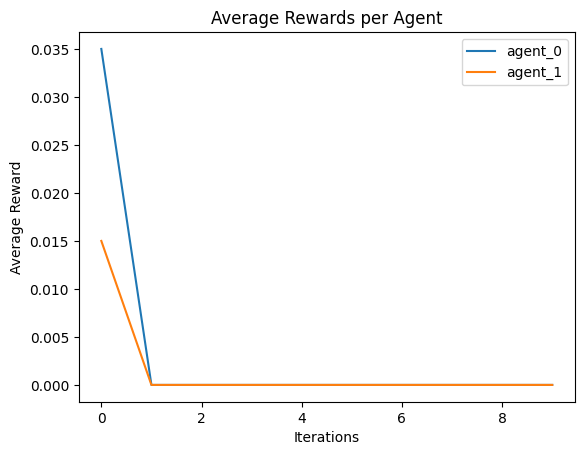

In [10]:
for agent, rewards in average_rewards.items():
    plt.plot(rewards, label=agent)

plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Average Rewards per Agent')
plt.legend()
plt.show()

In [11]:
for agent in game.agents:
    agents[agent].learn = False

In [12]:
play_episode(game, agents, verbose=True, render=False)

Step: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 1
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 action: 0 - NONE
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 2
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 action: 0 - NONE
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 3
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 action: 0 - NONE
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 4
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 action: 0 - NONE
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]


{'agent_0': 0.0, 'agent_1': 0.0}